In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/My Drive/Colab Notebooks')

Mounted at /content/drive


# Init Data fun


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import random

def load_data(filepath):
    """Load movie data from a CSV file."""
    return pd.read_csv(filepath)

def categorize_movies_by_genre(df, genre_keywords):
    """Categorize movies based on genre keywords in their summaries."""
    def categorize_by_genre(row):
        summary = str(row['Summary']).lower()
        for genre, keywords in genre_keywords.items():
            if any(keyword in summary for keyword in keywords):
                return genre
        return 'Other'

    df['Genre'] = df.apply(categorize_by_genre, axis=1)
    return df

def plot_genre_distribution(df):
    """Plot the distribution of movies across inferred genres."""
    df.groupby('Genre').size().plot(kind='barh', color=sns.color_palette('Dark2'))
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.show()

def pick_random(df, n):
    """Pick random moviees"""

    return df.sample(n)


# Message class

In [3]:
import json
import os

class Message:
    def __init__(self, sender, receiver, content):
        self.sender = sender
        self.receiver = receiver
        self.content = content

    def to_dict(self):
        return vars(self)


class Conversation:
    def __init__(self, file_path):
        self.file_path = file_path
        # Load existing messages if the file exists
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as f:
              try:
                self.messages = [Message(**msg) for msg in json.load(f)]
              except json.JSONDecodeError:
                self.messages = []
        else:
            self.messages = []

    def add_message(self, sender, receiver, content):
        self.messages.append(Message(sender, receiver, content))
        self.save_to_json()

    def save_to_json(self):
        with open(self.file_path, 'w', encoding='utf-8') as f:
            json.dump([message.to_dict() for message in self.messages], f, ensure_ascii=False, indent=4)

    def clear_history(self):
      self.messages = []

    def get_full_conversation(self):
            return " ".join(f"{msg.sender}: {msg.content}" for msg in self.messages)

# Movie_Recommender

In [4]:
import google.generativeai as genai
from google.colab import userdata
import textwrap
from IPython.display import display, Markdown, HTML

def Configure_api(name):
  gemini_api_secret_name = name
  try:
    GOOGLE_API_KEY=userdata.get(gemini_api_secret_name)
    genai.configure(api_key=GOOGLE_API_KEY)
  except Exception as e:
    # unknown error
    raise e

class MovieRecommender:
    def __init__(self, model_name='gemini-pro', conversation_file='conversation.json'):
      self.model = genai.GenerativeModel(model_name)
      self.conversation = Conversation(conversation_file)
      self.system_instructions = (
          "Please recommend movies based on the user's input and the information available in the dataset, from ratings to summaries. Provide a rationale for each suggested film. Your recommendations should be guided by the details from any previous conversation with the user. If there is no relevant preceding conversation, or if it doesn't provide necessary insights, you should answer the user's current query."
      )
    def recommend_movies(self, df_1, user_message):
          # Append user message to conversation history and prepare instructions
          full_conversation = self.conversation.get_full_conversation()

          instructions = f"""
          {df_1}
          Critical instructions:
          {self.system_instructions}
          Here is the conversation history: {full_conversation}
          User says: {user_message}
          """
          self.conversation.add_message('User', 'Bot', user_message)
          # Generate response from model
          response = self.model.generate_content(instructions)
          # Check if response has 'parts' attribute and it is not empty
          if hasattr(response, 'parts') and response.parts:
              bot_response = " ".join(part.text for part in response.parts if hasattr(part, 'text'))
          else:
              bot_response = "No response generated by the model."

          self.conversation.add_message('Bot', 'User', bot_response)

    def clear_history(self):
        self.conversation.clear_history()
        print("Conversation history has been cleared.")


In [5]:
from IPython.display import display, HTML, Markdown
import markdown

def display_conversation(MovieRecommender):
    for msg in MovieRecommender.conversation.messages:
        bg_color = "#f0f0f0" if msg.sender == "User" else "#f9f9f9"
        text_color = "black" if msg.sender == "User" else "darkgreen"
        html_content = f'''
            <div style="margin: 10px; padding: 8px; background-color: {bg_color}; color: {text_color};">
                <b>{msg.sender}:</b> {markdown.markdown(msg.content)}
            </div>
        '''
        display(HTML(html_content))

# Symmetric Semantic Search

In [6]:
pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 3.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [7]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import torch
def embeddings_data(df, model_name='all-MiniLM-L6-v2'):
  model = SentenceTransformer(model_name)
  if 'embeddings' not in df.columns:
      embeddings = model.encode(df['Summary'].tolist(), convert_to_tensor=True, show_progress_bar=True)
      df['embeddings'] = [emb.cpu().numpy().tolist() for emb in embeddings]
  return df
def get_recommendations(df, user_query, model):
    model = SentenceTransformer(model)
    query_embedding = model.encode(user_query)
    cosine_scores = util.pytorch_cos_sim(torch.tensor(query_embedding), torch.stack([torch.tensor(e) for e in df['embeddings']]))[0]
    df['Similarity'] = cosine_scores.numpy()
    return df.sort_values(by='Similarity', ascending=False).head(10)


# Run code

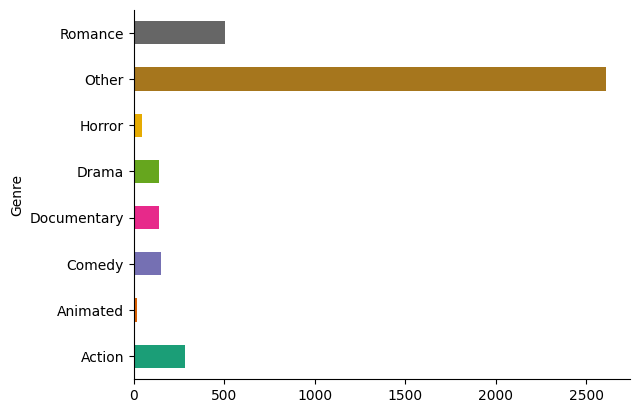

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/122 [00:00<?, ?it/s]

In [8]:
file_path = '/content/drive/MyDrive/Hydra-Movie-Scrape.csv'
genre_keywords = {
  'Comedy': ['comedy', 'funny', 'humor', 'happy'],
  'Drama': ['drama', 'tragedy', 'serious'],
  'Documentary': ['documentary', 'real life', 'true story'],
  'Animated': ['animated', 'animation', 'cartoon'],
  'Horror': ['horror', 'scary', 'frightening'],
  'Action': ['action', 'adventure', 'thrill'],
  'Romance': ['romance', 'love', 'romantic'],
}
# Load, categorize, and plot data
df = load_data(file_path)
df = categorize_movies_by_genre(df, genre_keywords)
plot_genre_distribution(df)
df = embeddings_data(df)
df.to_csv('embeddings_data.csv', index=False)

In [9]:
Configure_api("GOOGLE_API_KEY")
Recommender = MovieRecommender()

In [14]:
user_message = 'any other rec?' #@param {type: 'string'}
user_message = str(user_message)
df_top10 = get_recommendations(df, user_message, 'all-MiniLM-L6-v2')
Recommender.recommend_movies(df_top10, user_message)
display_conversation(Recommender)

In [11]:
type(user_message)

str

In [12]:
df

,Title,Year,Summary,Short Summary,IMDB ID,Runtime,YouTube Trailer,Rating,Movie Poster,Director,Writers,Cast,Genre,embeddings,Similarity
0,Patton Oswalt: Annihilation,2017,"Patton Oswald, despite a personal tragedy, pro...","Patton Oswalt, despite a personal tragedy, pro...",tt7026230,66,4hZi5QaMBFc,7.4,https://hydramovies.com/wp-content/uploads/201...,Bobcat Goldthwait,Patton Oswalt,Patton Oswalt,Drama,"[-0.025584105402231216, 0.030606774613261223, ...",0.128989
1,New York Doll,2005,A recovering alcoholic and recently converted ...,A recovering alcoholic and recently converted ...,tt0436629,75,jwD04NsnLLg,7.9,https://hydramovies.com/wp-content/uploads/201...,Greg Whiteley,Arthur Kane,Sylvain Sylvain,Other,"[-0.08467162400484085, -0.07572786509990692, -...",0.152512
2,Mickey's Magical Christmas: Snowed in at the H...,2001,After everyone is snowed in at the House of Mo...,Mickey and all his friends hold their own Chri...,tt0300195,65,uCKwHHftrU4,6.8,https://hydramovies.com/wp-content/uploads/201...,Tony Craig,Thomas Hart,Carlos Alazraqui|Wayne Allwine,Comedy,"[-0.009252047166228294, 0.029558513313531876, ...",0.220136
3,Mickey's House of Villains,2001,The villains from the popular animated Disney ...,The villains from the popular animated Disney ...,tt0329374,0,JA03ciYt-Ek,6.6,https://hydramovies.com/wp-content/uploads/201...,Jamie Mitchell,Thomas Hart,Tony Anselmo|Wayne Allwine,Animated,"[0.023140154778957367, 0.02852664142847061, 0....",0.159148
4,And Then I Go,2017,"In the cruel world of junior high, Edwin suffe...","In the cruel world of junior high, Edwin suffe...",tt2018111,99,8CdIiD6-iF0,7.6,https://hydramovies.com/wp-content/uploads/201...,Vincent Grashaw,Brett Haley,Arman Darbo|Sawyer Barth,Other,"[-0.023023098707199097, 0.059313978999853134, ...",0.113916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3881,The Cup,2011,"Born into a legendary racing family, jockeys D...","The 2002 Melbourne Cup horse race, brotherly l...",tt1650056,99,AyN06EoeEXU,5.7,https://hydramovies.com/wp-content/uploads/201...,Simon Wincer,Eric O'Keefe,Bryan Martin|Jodi Gordon|Stephen Curry,Other,"[0.025102797895669937, 0.05309220030903816, 0....",0.002525
3882,Faith in Destiny,2012,A fateful encounter sends a man on a journey t...,A fateful encounter sends a man on a journey t...,tt2271327,84,NaN,6.2,https://hydramovies.com/wp-content/uploads/201...,James Choi,James Choi,Keith Neagle|Sasha Daniel|Scott Woelfel,Other,"[-0.0009354953654110432, 0.014889656566083431,...",0.146953
3883,The Eye of the Storm,2011,"In the dead geographic center of American, a c...",Elizabeth Hunter controls all in her life - so...,tt1600207,114,g6ya76FbU1k,6.3,https://hydramovies.com/wp-content/uploads/201...,Fred Schepisi,Judy Morris,Charlotte Rampling|Geoffrey Rush|Maria Theodor...,Drama,"[0.005224289372563362, -0.08957720547914505, -...",0.093822
3884,Smitty,2012,Thirteen year-old city brat Ben (Brandon Tyler...,Thirteen year-old city brat Ben (Brandon Tyler...,tt1531914,94,YFVjnr1l5lU,5.2,https://hydramovies.com/wp-content/uploads/201...,David Mickey Evans,Michael Baumgarten,Brandon Tyler Russell|Freddie James|Peter Fonda,Other,"[-0.05309312045574188, 0.06534674018621445, 0....",0.212683
